In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [125]:
df = pd.read_csv("credit_card_default_analysis.csv")

In [126]:
df_0 = df[df.default == 0]

In [127]:
df_1 = df[df.default == 1]

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

([array([5.236e+03, 3.578e+03, 3.077e+03, 3.268e+03, 2.425e+03, 1.822e+03,
         1.049e+03, 1.322e+03, 4.950e+02, 9.090e+02, 6.500e+01, 4.500e+01,
         3.500e+01, 1.800e+01, 1.400e+01, 5.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 1.000e+00]),
  array([2.440e+03, 1.244e+03, 8.250e+02, 7.100e+02, 4.800e+02, 3.320e+02,
         1.570e+02, 2.310e+02, 7.800e+01, 1.160e+02, 1.100e+01, 6.000e+00,
         2.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00])],
 array([  10000.,   59500.,  109000.,  158500.,  208000.,  257500.,
         307000.,  356500.,  406000.,  455500.,  505000.,  554500.,
         604000.,  653500.,  703000.,  752500.,  802000.,  851500.,
         901000.,  950500., 1000000.]),
 <a list of 2 Lists of Patches objects>)

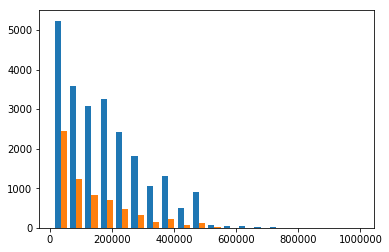

In [128]:
pylab.hist([df_0.LIMIT_BAL, df_1.LIMIT_BAL], 20, label = ["0", "1"])

Видим, что кредитный лимит у тех, кто отдал кредит - выше. В выборке много повторяющихся значений - поэтому используем 
перестановочный критерий для независимых выборок.

In [129]:
def get_bootstrap_samples(data, n_samples):
    data_length = len(data)
    indices = np.random.randint(0, data_length, (n_samples, data_length))
    return data[indices]
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
def median_conf_int(data, n_samples = 1000, alpha = 0.05):
    median = np.median(data)
    medians = map(lambda samples: np.median(samples), get_bootstrap_samples(data, n_samples))
    confint = stat_intervals(medians, alpha)
    return (median, confint)
def diff_median_conf_int(data_1, data_2, n_samples, alpha):
    median_1 = map(lambda samples: np.median(samples), get_bootstrap_samples(data_1, n_samples))
    median_2 = map(lambda samples: np.median(samples), get_bootstrap_samples(data_2, n_samples))
    return stat_intervals(map(lambda (s_median,d_median): s_median-d_median, zip(median_1, median_2)), alpha)

In [130]:
n_samples = 1000
alpha = 0.05
df_0_limit_confint = median_conf_int(df_0["LIMIT_BAL"].values, n_samples, alpha)
df_1_limit_confint = median_conf_int(df_1["LIMIT_BAL"].values, n_samples, alpha)
median_diff = diff_median_conf_int(df_0["LIMIT_BAL"].values, df_1["LIMIT_BAL"].values, n_samples, alpha)

In [131]:
print "df_0 median: %.4f\t Confidence interval: %s" % df_0_limit_confint
print "df_1 median: %.4f\t Confidence interval: %s" % df_1_limit_confint
print "Difference confidince interval: %s" % median_diff

df_0 median: 150000.0000	 Confidence interval: [150000. 150000.]
df_1 median: 90000.0000	 Confidence interval: [80000. 90000.]
Difference confidince interval: [60000. 70000.]


Доверительные интервалы не пересекаются. Интервал разницы медиан далеко отстоит от нуля. Медиана лимита для вернувших кредит 
значимо больше.

In [132]:
import itertools
def permutation_t_stat_ind(sample1, sample2):
    return np.median(sample1) - np.median(sample2)
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr
def permutation_test(sample1, sample2, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [133]:
print "p-value %.4f" % permutation_test(df_0["LIMIT_BAL"].values, df_1["LIMIT_BAL"].values, 
                                                               max_permutations=1000, alternative="two-sided")


p-value 0.0000


Значение p-value очень малое - гипотеза о равенстве распределений отвергается.

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. 
Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего 
статистического критерия)

In [134]:
cont_table = np.array([[((df.SEX == 1) & (df.default == 0)).sum(), ((df.SEX == 1) & (df.default == 1)).sum()], 
        [((df.SEX == 2) & (df.default == 0)).sum(), ((df.SEX == 2) & (df.default == 1)).sum()]])

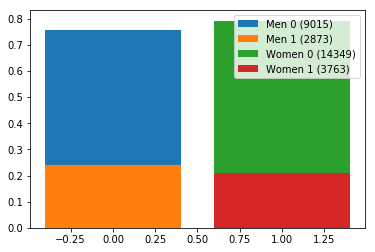

In [135]:
for (index, name) in enumerate(["Men", "Women"]):
    column_counts = map(lambda cell: float(cell), cont_table[index]) 
    for (column_count,column_name) in zip(column_counts, ["0", "1"]):
        pylab.bar(index, column_count/sum(column_counts), label = ("%s %s (%.0f)" % (name, column_name, column_count)))
pylab.legend()
pylab.show()
#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.

Визуально кажется, что доля мужчин вернувших кредит меньше доли женщин вернувших кредит.

In [136]:
def proportions_confint_diff(first_vector, second_vector, alpha = 0.05):
    count1 = float(len(first_vector))
    count2 = float(len(second_vector))
    p1 = float(len(filter(lambda x: x == 1, first_vector)))/count1
    p2 = float(len(filter(lambda x: x == 1, second_vector)))/count2
    z = stats.norm.ppf(1. - alpha / 2.)

    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1. - p1)/ count1 + p2 * (1 - p2)/ count2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1. - p1)/ count1 + p2 * (1 - p2)/ count2)
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(len(filter(lambda x: x == 1, sample1))) / n1
    p2 = float(len(filter(lambda x: x == 1, sample2))) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(sample1, sample2, alternative = 'two-sided'):
    z_stat = proportions_diff_z_stat_ind(sample1, sample2)
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [137]:
print "[%.4f; %.4f]" % proportions_confint_diff(df_0.SEX.values, df_1.SEX.values)

[-0.0605; -0.0336]


Отсюда следует, что доля мужчин не вернувших кредит больше, чем доля вернувших.

In [138]:
print proportions_diff_z_test(df_0.SEX.values, df_1.SEX.values, alternative='two-sided')

4.472866521609831e-12


Достигаемый уровень значимости мал, значит гипотеза о равенстве доли мужчин в выборках вернувших и не вернувших с 
уверенностью отвергается

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [140]:
def Cramer_correlation(table):
    chi_stat = stats.chi2_contingency(table)[0]
    k_min = np.min(table.shape)
    n = np.sum(table)
    return np.sqrt(chi_stat/(n*(k_min-1)))

Применяем критерий хи-квадрат

In [141]:
cont_table_ed = numpy.zeros((7,2))
for i in range (7):
    for j in range (2):
        cont_table_ed[i][j] = ((df.EDUCATION == i) & (df.default == j)).sum()
cont_table_ed

array([[1.400e+01, 0.000e+00],
       [8.549e+03, 2.036e+03],
       [1.070e+04, 3.330e+03],
       [3.680e+03, 1.237e+03],
       [1.160e+02, 7.000e+00],
       [2.620e+02, 1.800e+01],
       [4.300e+01, 8.000e+00]])

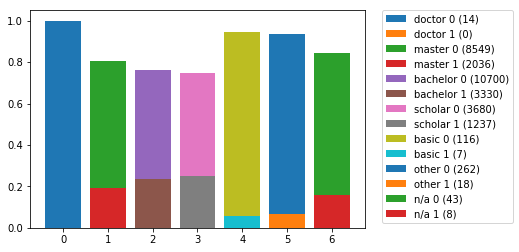

In [142]:
for (index, name) in enumerate(["doctor","master","bachelor","scholar","basic","other","n/a"]):
    column_counts = map(lambda cell: float(cell), cont_table_ed[index]) 
    for (column_count,column_name) in zip(column_counts, ["0", "1"]):
        pylab.bar(index, column_count/sum(column_counts), label = ("%s %s (%.0f)" % (name, column_name, column_count)))
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.show()

In [143]:
print "V-Cramer %.4f" % Cramer_correlation(cont_table_ed)
print stats.chi2_contingency(cont_table_ed)[1]

V-Cramer 0.0738
1.2332626245415605e-32


Значение коэффициента V Крамера мало, однако p-value позволяет отвергнуть гипотезу о не независимости.
Чаще всего отдают долг люди с докторской степенью.
А реже всего - люди со школьным образованием.

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, 
по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [145]:
cont_table_mar = numpy.zeros((4,2))
for i in range (4):
    for j in range (2):
        cont_table_mar[i][j] = ((df.MARRIAGE == i) & (df.default == j)).sum()
cont_table_mar

array([[4.9000e+01, 5.0000e+00],
       [1.0453e+04, 3.2060e+03],
       [1.2623e+04, 3.3410e+03],
       [2.3900e+02, 8.4000e+01]])

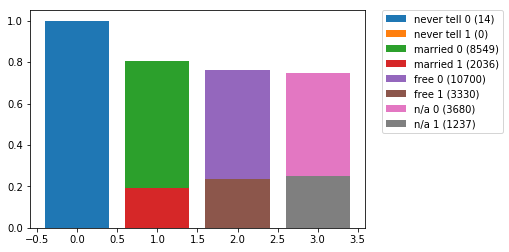

In [146]:
for (index, name) in enumerate(["never tell","married","free","n/a"]):
    column_counts = map(lambda cell: float(cell), cont_table_ed[index]) 
    for (column_count,column_name) in zip(column_counts, ["0", "1"]):
        pylab.bar(index, column_count/sum(column_counts), label = ("%s %s (%.0f)" % (name, column_name, column_count)))
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.show()

In [147]:
print "V-Cramer %.4f" % Cramer_correlation(cont_table_mar)
print stats.chi2_contingency(cont_table_mar)[1]

V-Cramer 0.0345
8.825862457577375e-08


Посчитали связь между семейным положением и возвратом/невозвратом с помощью коэффициента Крамера, а достигаемый уровень 
значимости с помощью коэффициента хи-квадрат. Коэффициент получился малым, однако гипотезу о независимости этих двух
признаков мы отвергаем ввиду малости p-value. В конечном итоге получаем, что семейное положение влияет на возврат, но слабо.

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

([array([4.440e+02, 1.511e+03, 1.887e+03, 2.287e+03, 2.413e+03, 1.921e+03,
         1.862e+03, 1.741e+03, 1.562e+03, 1.438e+03, 1.248e+03, 1.058e+03,
         9.140e+02, 7.430e+02, 3.330e+02, 5.620e+02, 4.770e+02, 3.430e+02,
         2.240e+02, 1.530e+02, 7.900e+01, 6.000e+01, 4.100e+01, 2.900e+01,
         1.600e+01, 1.100e+01, 3.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
  array([183., 547., 555., 599., 587., 454., 446., 480., 423., 386., 370.,
         312., 273., 224., 119., 189., 152., 113.,  76.,  52.,  44.,  15.,
          14.,  12.,   4.,   2.,   4.,   1.,   0.,   0.])],
 array([21.        , 22.93333333, 24.86666667, 26.8       , 28.73333333,
        30.66666667, 32.6       , 34.53333333, 36.46666667, 38.4       ,
        40.33333333, 42.26666667, 44.2       , 46.13333333, 48.06666667,
        50.        , 51.93333333, 53.86666667, 55.8       , 57.73333333,
        59.66666667, 61.6       , 63.53333333, 65.46666667, 67.4       ,
        69.33333333, 71.26666667, 73.2       , 7

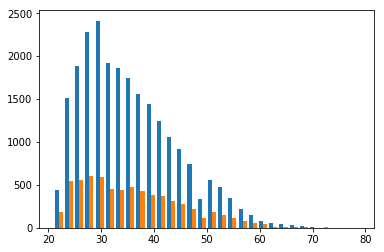

In [148]:
pylab.hist([df_0.AGE, df_1.AGE], 30, label = ["0", "1"])

Визуально распределения кажутся похожими.

In [149]:
age_1_confint = median_conf_int(df_1["AGE"].values, n_samples, alpha)
age_0_confint = median_conf_int(df_0["AGE"].values, n_samples, alpha)
median_delta_ages_confint = diff_median_conf_int(df_0["AGE"].values, df_1["AGE"].values, n_samples, alpha)
print "age_1 median: %.4f\tConfidence interval: %s" % age_1_confint
print "age_0 median: %.4f\tConfidence interval: %s" % age_0_confint
print "Confidence interval for difference  %s" % median_delta_ages_confint
print "Permutation criterion p-value: %.4f" % permutation_test(df_1["AGE"].values, df_0["AGE"].values, 
                                                               max_permutations=1000, alternative="two-sided")

age_1 median: 34.0000	Confidence interval: [34. 35.]
age_0 median: 34.0000	Confidence interval: [34. 34.]
Confidence interval for difference  [-1.  0.]
Permutation criterion p-value: 1.0000


Интервалы для медиан пересекаются, интервал для их разности содержит 0. Гипотеза о равенстве распределений не отвергается,
так как значение p-value велико.

Однако в конечном счете хочется сделать вывод, что рассмотренные признаки не самые влиятельные в вопросе возврата долга. Скорее 
всего более важным является доход и наличие работы у клиента.